In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import ta  # For technical indicators

In [2]:
# Step 1: Download historical S&P 500 data using yfinance
ticker = '^GSPC'  # S&P 500 index ticker symbol
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2022-12-23,3815.110107,3845.800049,3797.010010,3844.820068,3844.820068,2819280000
2022-12-27,3843.340088,3846.649902,3813.219971,3829.250000,3829.250000,3030300000
2022-12-28,3829.560059,3848.320068,3780.780029,3783.219971,3783.219971,3083520000


In [4]:
# Step 2: Feature Engineering
# Keep only the 'Close' price for the prediction
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
data['EMA50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['EMA200'] = ta.trend.ema_indicator(data['Close'], window=200)

In [5]:
# Add lagged features (previous days' prices)
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)

In [6]:
# Drop rows with NaN values (from rolling and shifting)
data = data.dropna()

In [7]:
# Step 3: Define features (X) and target (y)
X = data[['MA5', 'MA20', 'MA50', 'RSI', 'EMA50', 'EMA200', 'Lag1', 'Lag2', 'Lag3']].values
y = data['Close'].values

In [8]:
# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
# Step 5: Standardize the features using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

In [10]:
# Step 6: Initialize the SVR model and define a parameter grid for hyperparameter tuning
svr = SVR()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100,1000],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf']
}

In [11]:
# Step 7: Set up GridSearchCV to find the best hyperparameters with cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [12]:
# Step 8: Train the model using GridSearchCV
grid_search.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=1)

In [13]:
# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [14]:
# Step 9: Train the SVR model with the best parameters
svr_best = SVR(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
svr_best.fit(X_train_scaled, y_train_scaled)


SVR(C=100, gamma=0.001)

In [15]:
# Step 10: Make predictions on the test set
y_pred_scaled = svr_best.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten() # Inverse transform

In [16]:
# Step 11: Evaluate model performance
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R-squared: {r2_test}")

Test Mean Squared Error: 45690.39278654608
Test R-squared: 0.7044541829340081


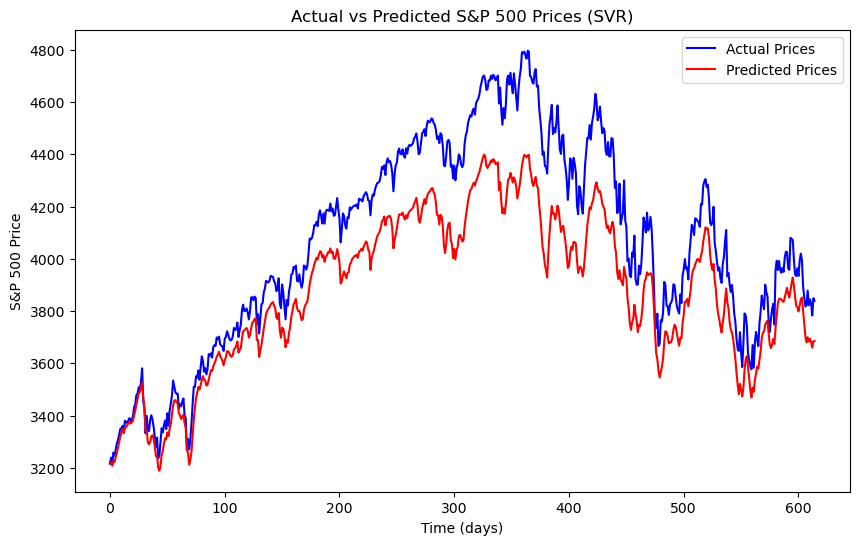

In [17]:
# Step 12: Plot actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted S&P 500 Prices (SVR)')
plt.xlabel('Time (days)')
plt.ylabel('S&P 500 Price')
plt.legend()
plt.show()

In [18]:
# Step 13: Predict the next day's price using the last row of the test set
last_row = X_test_scaled[-1, :].reshape(1, -1) # Get the last row of the test set
next_day_price = svr_best.predict(last_row)
print(f"Predicted next day price: {next_day_price[0]}")

Predicted next day price: 2.699459376659437
